## Imports

In [1]:
import numpy as np
import cv2
import glob
import time
import pickle
from collections import deque
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
%matplotlib inline

from skimage.feature import hog
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle
# from sklearn.cross_validation import train_test_split  # for scikit-learn version <= 0.17
from sklearn.model_selection import train_test_split  # if you are using scikit-learn >= 0.18
from scipy.ndimage.measurements import label
from moviepy.editor import VideoFileClip

from includes.car_classification import *
from includes.car_detection import *
from includes.lanes_camera_calibration import *
from includes.lanes_detection import *

## Calibrate camera (for lane detection)
Not necessary if calibration pickle file is present

In [ ]:
filename = 'test_images/test1.jpg'
img = cv2.imread(filename)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img_size = (img.shape[1], img.shape[0])

mtx, dist = camera_calibration(img_size)

## Train classifier (for car detection)
Not necessary if model pickle file is present

In [ ]:
cars = glob.glob('car_classification_datasets/vehicles/**/*.png', recursive=True)
notcars = glob.glob('car_classification_datasets/non-vehicles/**/*.png', recursive=True)
print('Car images: {}'.format(len(cars)))
print('Non-car images: {}'.format(len(notcars)))

# sample_size = 100
sample_size = None
if sample_size is not None:
    cars = cars[0:sample_size]
    notcars = notcars[0:sample_size]
    
## Feature parameters
parameters = {'colorspace': 'YCrCb',            # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
              'hog_channel': 'ALL',             # Can be 0, 1, 2, or "ALL"
              'hog_orient': 9,                  # HOG possible orientations    9 11
              'hog_pix_per_cell': 8,            # HOG number of px per cell    8 16
              'hog_cell_per_block': 2,          # HOG number of cells per block
              'spatial_size': (32, 32),         # Spatial binning dimensions
              'histogram_bins': 32}             # Number of histogram bins

if 0:
    # Extract features for writeup
    extract_features_from_image_list(cars[100:106], show_intermediate=True)

if 1:
    train_classifier(cars, notcars, parameters, "model_linearsvc_9_8")

## Code to merge the two algorithms

In [2]:
# Load camera calibration parameters
cal = pickle.load(open("camera_calibration/calibration.p", "rb"))
mtx = cal["mtx"]
dist = cal["dist"]

# Load car classifier and scaler
model = pickle.load(open("models/model_linearsvc_9_8.p", "rb"))
svc = model["model"]
scaler = model["scaler"]
colorspace = model["colorspace"]
hog_channel = model["hog_channel"]
hog_orient = model["hog_orient"]
hog_pix_per_cell = model["hog_pix_per_cell"]
hog_cell_per_block = model["hog_cell_per_block"]
spatial_size = model["spatial_size"]
histogram_bins = model["histogram_bins"]

# Common pipeline
def common_pipeline(img):
    lane_output = lane_detector.pipeline(img)
    car_output = detector.search_in_image(img)
    
    # tmp = cv2.addWeighted(img, 1.0, lane_output, 1.0, 0.0)
    # output = cv2.addWeighted(tmp, 1.0, car_output, 1.0, 0.0)
    
    tmp = cv2.add(img, lane_output)
    output = cv2.add(tmp, car_output)
    
    return output

## Test on single image

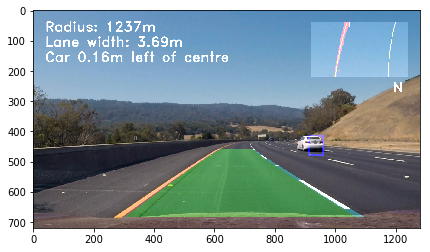

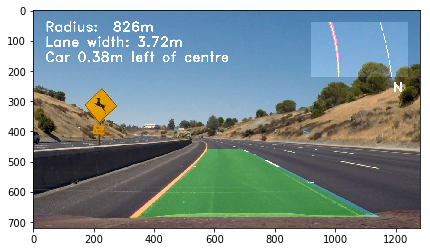

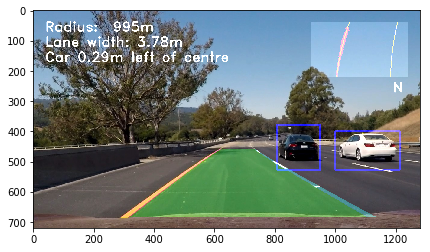

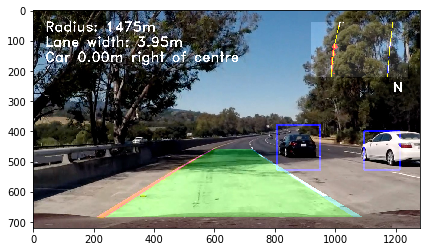

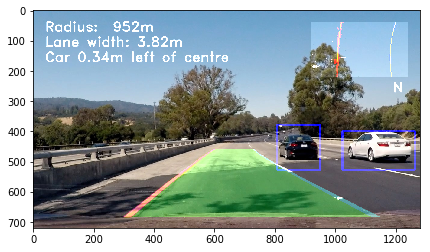

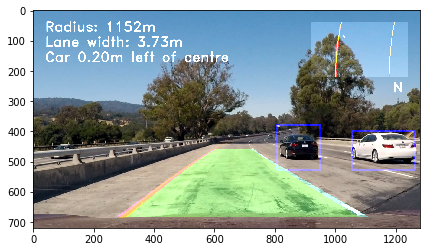

In [3]:
# Load test images
images = glob.glob('test_images/*.jpg')
# images = ['test_images/test6.jpg']

for file in images:
    img = mpimg.imread(file)
    #img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    lane_detector = LaneDetection(mtx=mtx,
                                  dist=dist,
                                  full_output=False)
    
    detector = VehicleDetector(classifier=svc,
                               scaler=scaler,
                               colorspace=colorspace,
                               hog_channel=hog_channel,
                               hog_orient=hog_orient,
                               hog_pix_per_cell=hog_pix_per_cell,
                               hog_cell_per_block=hog_cell_per_block,
                               spatial_size=spatial_size,
                               histogram_bins=histogram_bins,
                               show_intermediate_results=False,
                               full_output=False)
    
    output = common_pipeline(img)
    
    f, ax = plt.subplots(1, 1, figsize=(8,4))
    ax.imshow(output)
        

## Test on video

In [4]:
# File to process
filename = "videos/project_video.mp4"
# filename = "test_videos/challenge_video.mp4"
# filename = "test_videos/harder_challenge_video.mp4"
clip = VideoFileClip(filename)
white_output = filename[:-4] + '_vehicles_and_lane.mp4'

# Create and initialize objects
lane_detector = LaneDetection(mtx=mtx,
                              dist=dist,
                              full_output=False)
    
detector = VehicleDetector(classifier=svc,
                           scaler=scaler,
                           colorspace=colorspace,
                           hog_channel=hog_channel,
                           hog_orient=hog_orient,
                           hog_pix_per_cell=hog_pix_per_cell,
                           hog_cell_per_block=hog_cell_per_block,
                           spatial_size=spatial_size,
                           histogram_bins=histogram_bins,
                           show_intermediate_results=False,
                           full_output=False)

# Process video
white_clip = clip.fl_image(common_pipeline)
# white_clip = clip.fl_image(common_pipeline).subclip(8, 10)
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video videos/project_video_vehicles_and_lane.mp4
[MoviePy] Writing video videos/project_video_vehicles_and_lane.mp4


100%|█████████▉| 1260/1261 [29:13<00:01,  1.60s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: videos/project_video_vehicles_and_lane.mp4 

CPU times: user 38min 59s, sys: 8.29 s, total: 39min 7s
Wall time: 29min 13s
